<a href="https://colab.research.google.com/github/Jarvis017/Blood_Glucose_Prediction/blob/main/Mixture_of_Experts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Section


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import datetime
import csv
import pickle
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import Normalizer

# Loading and Transforming data

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open("/content/drive/MyDrive/dataset/CGM/X data_PH30", 'rb') as f:
    X = pickle.load(f)
with open("/content/drive/MyDrive/dataset/CGM/y data_PH30", 'rb') as f:
    y = pickle.load(f)

In [ ]:
with open("/content/drive/MyDrive/dataset/CGM/X data_PH15", 'rb') as f:
    X = pickle.load(f)
with open("/content/drive/MyDrive/dataset/CGM/y data_PH15", 'rb') as f:
    y = pickle.load(f)
with open("/content/drive/MyDrive/dataset/CGM/X final feature data", 'rb') as f:
    X_feature = pickle.load(f)

In [ ]:
X = np.reshape(X, (len(X), len(X[1])))
y = np.reshape(y, (len(y), 1))
X_feature = np.squeeze(X_feature)

In [ ]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)
X_feature = torch.from_numpy(X_feature)
X = X.to(torch.float32)
y = y.to(torch.float32)
X_feature = X_feature.to(torch.float32)

In [ ]:
X.shape, y.shape, X_feature.shape

(torch.Size([497385, 6]), torch.Size([497385, 1]), torch.Size([497385, 22]))

# Splitting the data

In [ ]:
#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size= 0.2)

In [ ]:
cut_off_1 = 0.7
cut_off_2 = 0.2

X_train = X[:int(len(X)*cut_off_1)]
X_feature_train = X_feature[:int(len(X_feature)*cut_off_1)]
y_train = y[:int(len(X)*cut_off_1)]

X_validation = X[int(len(X)*cut_off_1):int(len(X)*cut_off_1)+int(len(X)*cut_off_2)]
X_feature_validation = X_feature[int(len(X_feature)*cut_off_1):int(len(X_feature)*cut_off_1)+int(len(X_feature)*cut_off_2)]
y_validation = y[int(len(X)*cut_off_1):int(len(X)*cut_off_1)+int(len(X)*cut_off_2)]

X_test = X[int(len(X)*cut_off_1)+int(len(X)*cut_off_2):]
X_feature_test = X_feature[int(len(X_feature)*cut_off_1)+int(len(X_feature)*cut_off_2):]
y_test = y[int(len(X)*cut_off_1)+int(len(X)*cut_off_2):]

(len(X_train) + len(X_validation) + len(X_test)),len(X)

(497385, 497385)

In [ ]:
batch_size = 128
train_dataLoader = DataLoader([ [(X_train[i],X_feature_train[i]), y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size,drop_last=True)
validation_dataLoader = DataLoader([ [(X_validation[i],X_feature_validation[i]), y_validation[i]] for i in range(len(y_validation))], shuffle=True, batch_size=batch_size,drop_last=True)
test_dataLoader = DataLoader([ [(X_test[i],X_feature_test[i]), y_test[i]] for i in range(len(y_test))], shuffle=True, batch_size=batch_size,drop_last=True)

# Train and Validation Function

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


def train(dataloader, model, LossFuction, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error

        pred = model(X)
        loss = torch.sqrt(LossFuction(pred, y))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"RMSE: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    avg_train_loss = total_train_loss / len(dataloader)
    print("  Train RMSE: {0:.2f}".format(avg_train_loss))
    return avg_train_loss

def validation(dataloader, model, LossFuction):

  model.eval()
  total_eval_loss = 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    with torch.no_grad():
      pred = model(X)
      loss = torch.sqrt(LossFuction(pred, y))
      total_eval_loss += loss.item()

  avg_val_loss = total_eval_loss / len(dataloader)
  print("  Validation RMSE: {0:.2f}".format(avg_val_loss))

  return avg_val_loss



In [ ]:
def train_with_attribute(dataloader, model, LossFuction, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_train_loss = 0
    for batch, ((X,X1), y) in enumerate(dataloader):
        X, X1, y = X.to(device), X1.to(device), y.to(device)
        # Compute prediction error

        pred = model(X,X1)
        loss = torch.sqrt(LossFuction(pred, y))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"RMSE: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    avg_train_loss = total_train_loss / len(dataloader)
    print("  Train RMSE: {0:.2f}".format(avg_train_loss))
    return avg_train_loss

def validation_with_attribute(dataloader, model, LossFuction):

  model.eval()
  total_eval_loss = 0

  for batch, ((X,X1), y) in enumerate(dataloader):
    X, X1, y = X.to(device), X1.to(device), y.to(device)

    with torch.no_grad():
      pred = model(X,X1)
      loss = torch.sqrt(LossFuction(pred, y))
      total_eval_loss += loss.item()

  avg_val_loss = total_eval_loss / len(dataloader)
  print("  Validation RMSE: {0:.2f}".format(avg_val_loss))

  return avg_val_loss


# Models

In [ ]:
x = torch.randn(2, 3)
z = torch.cat((x, x, x), 0)
z.shape

torch.Size([6, 3])

# GRU-LSTM-Linear Model

In [ ]:
class GRU(nn.Module):
    def __init__(self,input_size, num_layers, hidden_size, output_size,batch_size):
        super().__init__()

        self.gru = nn.GRU(input_size,hidden_size,num_layers)
        self.denseG1 = nn.Linear(hidden_size,64)
        self.denseG2 = nn.Linear(64,32)
        self.denseG3 = nn.Linear(32,16)
        self.denseG4 = nn.Linear(16,output_size)

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.denseL1 = nn.Linear(hidden_size,64)
        self.denseL2 = nn.Linear(64,32)
        self.denseL3 = nn.Linear(32,16)
        self.denseL4 = nn.Linear(16,output_size)

        self.dense = nn.Sequential(
            nn.Linear(input_size,128),
            nn.Linear(128,64),
            nn.Linear(64,32),
            nn.Linear(32,1)
        )

        self.gating_layer = nn.Sequential(
            nn.Linear(input_size,64),
            nn.Linear(64,32),
            nn.Linear(32,batch_size),
            nn.Linear(batch_size,batch_size)
        )
        self.Softmax = nn.Softmax(dim = 1)


    def forward(self, input):
        expert_outputs = []
        outputG, _ = self.gru(input)
        outputG = self.denseG1(outputG)
        outputG = self.denseG2(outputG)
        outputG = self.denseG3(outputG)
        outputG = self.denseG4(outputG)
        expert_outputs.append(outputG)

        outputL, _ = self.lstm(input)
        outputL = self.denseL1(outputL)
        outputL = self.denseL2(outputL)
        outputL = self.denseL3(outputL)
        outputL = self.denseL4(outputL)
        expert_outputs.append(outputL)

        outputD = self.dense(input)
        expert_outputs.append(outputD)

        expert_outputs = torch.stack(expert_outputs, dim=1)
        expert_outputs = torch.squeeze(expert_outputs)

        gating_weights = self.gating_layer(input)

        gating_weights = torch.matmul(gating_weights, expert_outputs)
        gating_weights = self.Softmax(gating_weights)
        weighted_sum = torch.sum(expert_outputs * gating_weights,dim = 1)
        weighted_sum = weighted_sum.view(len(weighted_sum),1)


        return weighted_sum


## Run

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model = GRU(input_size = 5, num_layers=2, hidden_size = 512,
                             output_size = 1,batch_size=batch_size)

model = model.to(device)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
LossFuction = nn.MSELoss()
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
training_stats = []
for t in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(t + 1, epochs))
    print('Training...')
    train_loss = train(train_dataLoader, model, LossFuction, optimizer)
    print("")
    print("Running Validation...")
    val_loss = validation(validation_dataLoader, model, LossFuction)
    training_stats.append(
        {
            'epoch': t + 1,
            'Training Loss': train_loss,
            'Validation Loss': val_loss
        }
    )


print("Done!")


======== Epoch 1 / 10 ========
Training...
RMSE: 187.283722  [    8/334061]
RMSE: 8.509359  [  808/334061]
RMSE: 34.332043  [ 1608/334061]
RMSE: 20.514744  [ 2408/334061]
RMSE: 13.667661  [ 3208/334061]
RMSE: 10.624664  [ 4008/334061]
RMSE: 19.434986  [ 4808/334061]
RMSE: 7.553017  [ 5608/334061]
RMSE: 15.050520  [ 6408/334061]
RMSE: 11.092941  [ 7208/334061]
RMSE: 14.498133  [ 8008/334061]
RMSE: 9.892831  [ 8808/334061]
RMSE: 15.450682  [ 9608/334061]
RMSE: 18.491585  [10408/334061]
RMSE: 18.763187  [11208/334061]
RMSE: 13.171947  [12008/334061]
RMSE: 8.753273  [12808/334061]
RMSE: 14.319757  [13608/334061]
RMSE: 15.471990  [14408/334061]
RMSE: 27.164196  [15208/334061]
RMSE: 14.253241  [16008/334061]
RMSE: 10.894207  [16808/334061]
RMSE: 11.653986  [17608/334061]
RMSE: 8.074268  [18408/334061]
RMSE: 12.489043  [19208/334061]
RMSE: 5.960111  [20008/334061]
RMSE: 16.860050  [20808/334061]
RMSE: 20.003933  [21608/334061]
RMSE: 12.588036  [22408/334061]
RMSE: 11.911770  [23208/334061]
R

## Report

In [ ]:
stats = pd.DataFrame(data=training_stats)
stats = stats.set_index('epoch')
stats

,Training Loss,Validation Loss
epoch,,
1,14.439187,14.117355
2,14.089524,13.948394
3,13.981335,14.989743
4,13.900535,13.964557
5,13.865051,14.479974
6,13.840158,13.906623
7,13.825504,13.950612
8,13.801228,15.302330
9,13.795437,13.992185


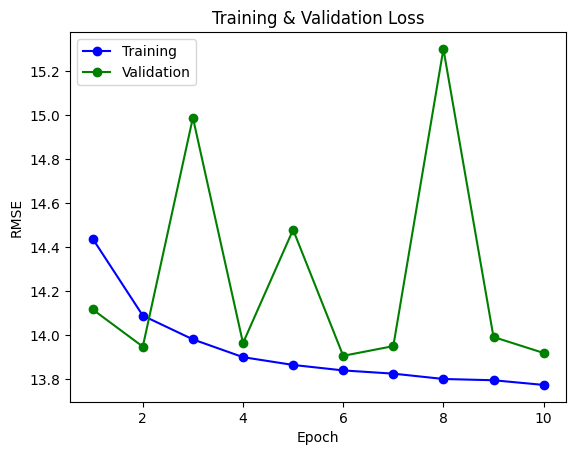

In [ ]:
plt.plot(stats['Training Loss'], 'b-o', label="Training")
plt.plot(stats['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()

# GRU-LSTM-Linear2 Model

In [ ]:
class MoE(nn.Module):
    def __init__(self,input_size, num_layers, hidden_size, output_size,batch_size):
        super().__init__()

        self.gru = nn.GRU(input_size,hidden_size,num_layers)
        self.denseG1 = nn.Linear(hidden_size,64)
        self.denseG2 = nn.Linear(64,32)
        self.denseG4 = nn.Linear(32,output_size)
        self.dropoutG1 = nn.Dropout(0.3)
        self.dropoutG2 = nn.Dropout(0.3)

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.denseL1 = nn.Linear(hidden_size,64)
        self.denseL2 = nn.Linear(64,32)
        self.denseL4 = nn.Linear(32,output_size)
        self.dropoutL1 = nn.Dropout(0.3)
        self.dropoutL2 = nn.Dropout(0.3)

        self.dense = nn.Sequential(
            nn.Linear(input_size,128),
            nn.Linear(128,64),
            nn.Linear(64,32),
            nn.Linear(32,1)
        )

        self.gating_layer = nn.Sequential(
            nn.Linear(input_size,64),
            nn.Linear(64,32),
            nn.Linear(32,batch_size),
            nn.Linear(batch_size,batch_size)
        )
        self.Softmax = nn.Softmax(dim = 1)


    def forward(self, input):
        expert_outputs = []
        outputG, _ = self.gru(input)
        outputG = self.denseG1(outputG)
        #outputG = self.dropoutG1(outputG)
        outputG = self.denseG2(outputG)
        outputG = self.denseG4(outputG)
        outputG = self.dropoutG2(outputG)
        expert_outputs.append(outputG)

        outputL, _ = self.lstm(input)
        outputL = self.denseL1(outputL)
        #outputL = self.dropoutL1(outputL)
        outputL = self.denseL2(outputL)
        outputL = self.denseL4(outputL)
        outputL = self.dropoutL2(outputL)
        expert_outputs.append(outputL)

        outputD = self.dense(input)
        expert_outputs.append(outputD)

        expert_outputs = torch.stack(expert_outputs, dim=1)
        expert_outputs = torch.squeeze(expert_outputs)

        gating_weights = self.gating_layer(input)

        gating_weights = torch.matmul(gating_weights, expert_outputs)
        gating_weights = self.Softmax(gating_weights)
        weighted_sum = torch.sum(expert_outputs * gating_weights,dim = 1)
        weighted_sum = weighted_sum.view(len(weighted_sum),1)


        return weighted_sum


## Run

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model = MoE(input_size = 10, num_layers=2, hidden_size = 128,
                             output_size = 1,batch_size=batch_size)

model = model.to(device)

LossFuction = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
training_stats = []
for t in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(t + 1, epochs))
    print('Training...')
    train_loss = train(train_dataLoader, model, LossFuction, optimizer)
    print("")
    print("Running Validation...")
    val_loss = validation(validation_dataLoader, model, LossFuction)
    training_stats.append(
        {
            'epoch': t + 1,
            'Training Loss': train_loss,
            'Validation Loss': val_loss
        }
    )


print("Done!")


======== Epoch 1 / 10 ========
Training...
RMSE: 202.825043  [   16/318881]
RMSE: 26.731449  [ 1616/318881]
RMSE: 20.566715  [ 3216/318881]
RMSE: 29.536068  [ 4816/318881]
RMSE: 34.491737  [ 6416/318881]
RMSE: 26.884665  [ 8016/318881]
RMSE: 30.704641  [ 9616/318881]
RMSE: 32.424011  [11216/318881]
RMSE: 28.954720  [12816/318881]
RMSE: 25.331654  [14416/318881]
RMSE: 24.934578  [16016/318881]
RMSE: 23.930290  [17616/318881]
RMSE: 28.461843  [19216/318881]
RMSE: 13.077121  [20816/318881]
RMSE: 35.841370  [22416/318881]
RMSE: 31.629530  [24016/318881]
RMSE: 25.830194  [25616/318881]
RMSE: 21.663671  [27216/318881]
RMSE: 28.513660  [28816/318881]
RMSE: 21.082064  [30416/318881]
RMSE: 26.283575  [32016/318881]
RMSE: 20.072256  [33616/318881]
RMSE: 26.601950  [35216/318881]
RMSE: 18.664047  [36816/318881]
RMSE: 18.153652  [38416/318881]
RMSE: 29.630356  [40016/318881]
RMSE: 30.332987  [41616/318881]
RMSE: 21.170803  [43216/318881]
RMSE: 22.281738  [44816/318881]
RMSE: 14.054669  [46416/318

In [ ]:
stats = pd.DataFrame(data=training_stats)
stats = stats.set_index('epoch')
stats

,Training Loss,Validation Loss
epoch,,
1,24.995957,25.939394
2,24.431312,24.001464
3,24.334868,24.148436
4,24.235899,24.905400
5,24.199553,24.043527
6,24.168582,24.019266
7,24.139089,24.052918
8,24.122409,24.056997
9,24.107305,24.263804


import numpy as np
from google.colab import autoviz
df_307016624566978472 = autoviz.get_df('df_307016624566978472')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_307016624566978472, *['epoch'], **{})
chart

import numpy as np
from google.colab import autoviz
df_307016624566978472 = autoviz.get_df('df_307016624566978472')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_307016624566978472, *['Training Loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_307016624566978472 = autoviz.get_df('df_307016624566978472')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_307016624566978472, *['Validation Loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_307016624566978472 = autoviz.get_df('df_307016624566978472')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_307016624566978472, *['epoch'], **{})
chart

import numpy as np
from google.colab import autoviz
df_307016624566978472 = autoviz.get_df('df_307016624566978472')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_307016624566978472, *['Training Loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_307016624566978472 = autoviz.get_df('df_307016624566978472')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_307016624566978472, *['Validation Loss'], **{})
chart

import numpy as np
from google.colab import autoviz
df_307016624566978472 = autoviz.get_df('df_307016624566978472')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_307016624566978472, *[[['epoch', 'Training Loss'], ['Training Loss', 'Validation Loss']]], **{})
chart

import numpy as np
from google.colab import autoviz
df_307016624566978472 = autoviz.get_df('df_307016624566978472')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_307016624566978472, *['epoch', 'Training Loss', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_307016624566978472 = autoviz.get_df('df_307016624566978472')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_307016624566978472, *['epoch', 'Validation Loss', None], **{})
chart

import numpy as np
from google.colab import autoviz
df_307016624566978472 = autoviz.get_df('df_307016624566978472')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_307016624566978472, *['epoch', 'count()', None], **{})
chart

## Report

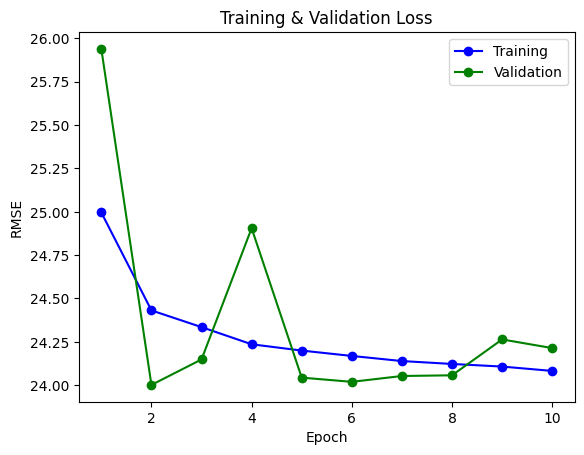

In [ ]:
plt.plot(stats['Training Loss'], 'b-o', label="Training")
plt.plot(stats['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()

# MoE with attributes

In [ ]:
class NewMoE(nn.Module):
    def __init__(self,input_size, num_layers, hidden_size, output_size,batch_size):
        super().__init__()

        # GRU Expert
        self.gru1 = nn.GRU(input_size,hidden_size)
        self.gru2 = nn.GRU(hidden_size,128)
        self.gru3 = nn.GRU(128,64)
        self.denseG1 = nn.Linear(64,16)
        #self.denseG2 = nn.Linear(64,32)
        #self.denseG2_2 = nn.Linear(32,16)

        # Attribute of GRU
        self.denseAG1 = nn.Linear(22,64)
        self.denseAG2 = nn.Linear(64,32)
        self.denseAG3 = nn.Linear(32,16)

        self.denseG3 = nn.Linear(32,16)
        self.denseG4 = nn.Linear(16,output_size)

        # LSTM Expert
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size= 128)
        self.lstm3 = nn.LSTM(input_size = 128, hidden_size= 64)
        self.denseL1 = nn.Linear(64,16)
        #self.denseL2 = nn.Linear(64,32)
        #self.denseL2_2 = nn.Linear(32,16)

        # Attribute of LSTM
        self.denseAL1 = nn.Linear(22,64)
        self.denseAL2 = nn.Linear(64,32)
        self.denseAL3 = nn.Linear(32,16)

        self.denseL3 = nn.Linear(32,16)
        self.denseL4 = nn.Linear(16,output_size)

        # Dense Expert
        self.dense = nn.Sequential(
            nn.Linear(input_size,64),
            #nn.Linear(128,64),
            nn.Linear(64,32),
            nn.Linear(32,16)
        )

        # Attribute of Dense
        self.denseAD1 = nn.Linear(22,64)
        self.denseAD2 = nn.Linear(64,32)
        self.denseAD3 = nn.Linear(32,16)

        self.denseD1 = nn.Linear(32,16)
        self.denseD2 = nn.Linear(16,output_size)

        # Gating Network
        self.gating_layer = nn.Sequential(
            nn.Linear(input_size,32),
            #nn.Linear(64,32),
            nn.Linear(32,batch_size),
            nn.Linear(batch_size,batch_size)
        )
        self.Softmax = nn.Softmax(dim = 1)


    def forward(self, input, features):
        expert_outputs = []

        #GRU
        outputG, _ = self.gru1(input)
        outputG, _ = self.gru2(outputG)
        outputG, _ = self.gru3(outputG)
        outputG = self.denseG1(outputG)
        #outputG = self.denseG2(outputG)
        #outputG = self.denseG2_2(outputG)

        outputAG = self.denseAG1(features)
        outputAG = self.denseAG2(outputAG)
        outputAG = self.denseAG3(outputAG)

        outputG = torch.cat((outputG,outputAG),1)
        outputG = self.denseG3(outputG)
        outputG = self.denseG4(outputG)
        expert_outputs.append(outputG)

        #LSTM
        outputL, _ = self.lstm1(input)
        outputL, _ = self.lstm2(outputL)
        outputL, _ = self.lstm3(outputL)
        outputL = self.denseL1(outputL)
        #outputL = self.denseL2(outputL)
        #outputL = self.denseL2_2(outputL)

        outputAL = self.denseAL1(features)
        outputAL = self.denseAL2(outputAL)
        outputAL = self.denseAL3(outputAL)

        outputL = torch.cat((outputL,outputAL),1)
        outputL = self.denseL3(outputL)
        outputL = self.denseL4(outputL)
        expert_outputs.append(outputL)

        #Dense
        outputD = self.dense(input)

        outputAD = self.denseAD1(features)
        outputAD = self.denseAD2(outputAD)
        outputAD = self.denseAD3(outputAD)

        outputD = torch.cat((outputD,outputAD),1)
        outputD = self.denseD1(outputD)
        outputD = self.denseD2(outputD)
        expert_outputs.append(outputD)


        expert_outputs = torch.stack(expert_outputs, dim=1)
        expert_outputs = torch.squeeze(expert_outputs)

        gating_weights = self.gating_layer(input)

        gating_weights = torch.matmul(gating_weights, expert_outputs)
        gating_weights = self.Softmax(gating_weights)
        weighted_sum = torch.sum(expert_outputs * gating_weights,dim = 1)
        weighted_sum = weighted_sum.view(len(weighted_sum),1)


        return weighted_sum


## Run

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model = NewMoE(input_size = 6, num_layers=3, hidden_size = 256,
                             output_size = 1,batch_size=batch_size)

model = model.to(device)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
LossFuction = nn.MSELoss()
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5
training_stats = []
for t in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(t + 1, epochs))
    print('Training...')
    train_loss = train_with_attribute(train_dataLoader, model, LossFuction, optimizer)
    print("")
    print("Running Validation...")
    val_loss = validation_with_attribute(validation_dataLoader, model, LossFuction)
    training_stats.append(
        {
            'epoch': t + 1,
            'Training Loss': train_loss,
            'Validation Loss': val_loss
        }
    )


print("Done!")


======== Epoch 1 / 5 ========
Training...
RMSE: 197.498993  [  128/348169]
RMSE: 87.092552  [12928/348169]
RMSE: 77.310104  [25728/348169]
RMSE: 61.964149  [38528/348169]
RMSE: 21.288658  [51328/348169]
RMSE: 23.677416  [64128/348169]
RMSE: 19.916260  [76928/348169]
RMSE: 38.835796  [89728/348169]
RMSE: 14.609914  [102528/348169]
RMSE: 16.092850  [115328/348169]
RMSE: 21.785480  [128128/348169]
RMSE: 17.095350  [140928/348169]
RMSE: 15.436072  [153728/348169]
RMSE: 14.936194  [166528/348169]
RMSE: 19.016560  [179328/348169]
RMSE: 15.553636  [192128/348169]
RMSE: 17.144081  [204928/348169]
RMSE: 14.943987  [217728/348169]
RMSE: 14.284806  [230528/348169]
RMSE: 20.589659  [243328/348169]
RMSE: 14.447047  [256128/348169]
RMSE: 18.081514  [268928/348169]
RMSE: 14.928061  [281728/348169]
RMSE: 14.317691  [294528/348169]
RMSE: 17.447084  [307328/348169]
RMSE: 16.771536  [320128/348169]
RMSE: 17.551390  [332928/348169]
RMSE: 15.888751  [345728/348169]
  Train RMSE: 26.41

Running Validation.

KeyboardInterrupt: ignored

## Report

In [ ]:
stats = pd.DataFrame(data=training_stats)
stats = stats.set_index('epoch')
stats

,Training Loss,Validation Loss
epoch,,
1,15.008487,14.326478
2,14.463680,14.327433
3,14.410162,14.394391
4,14.383338,14.446386
5,14.351580,14.617014


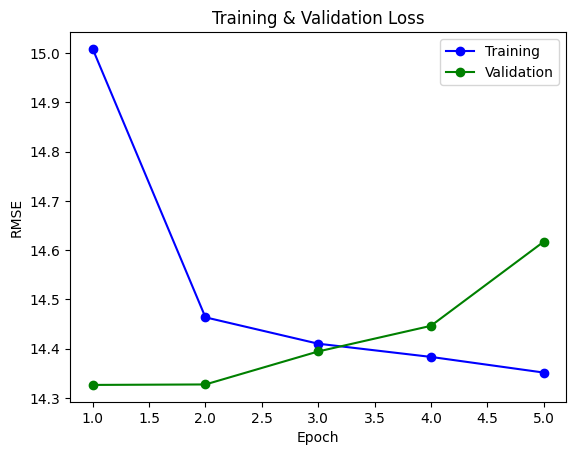

In [ ]:
plt.plot(stats['Training Loss'], 'b-o', label="Training")
plt.plot(stats['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()